In [ ]:
! wget https://www.dropbox.com/s/w38mycvausljkxd/basset_testset.h5
! wget https://www.dropbox.com/s/m9ji39gtptxtehl/basset_exponential.hdf5
! wget https://www.dropbox.com/s/6b1vlhss1p2dk8l/basset_relu.hdf5

--2022-08-12 00:03:15--  https://www.dropbox.com/s/w38mycvausljkxd/basset_testset.h5
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/w38mycvausljkxd/basset_testset.h5 [following]
--2022-08-12 00:03:15--  https://www.dropbox.com/s/raw/w38mycvausljkxd/basset_testset.h5
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc67f23eb5e7c7f3b4ce434faf00.dl.dropboxusercontent.com/cd/0/inline/Bq23E0A1Tpt56c70581PRT4B5uyNr-_gioLlPTJ0MrLZRiPXmsxrHfdFNrh3_Z_jp913448UnrlgjY-x3VHQK5lYZ1-93hGAy4UTuUatp4Rs1Fxv6nmXK_FE_dC4ycYp_mnvFhB02FBS-Lnezllugqpu_QZ4_f1AVbTjzlBsJviplg/file# [following]
--2022-08-12 00:03:16--  https://uc67f23eb5e7c7f3b4ce434faf00.dl.dropboxusercontent.com/cd/0/inline/Bq23E0A1Tpt56c70581PRT4B5uyNr-_gioLlPTJ0MrLZRiPXmsxrH

In [ ]:
! python -m pip install https://github.com/p-koo/tfomics/tarball/master
! pip install logomaker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://github.com/p-koo/tfomics/tarball/master


In [ ]:
import h5py

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import numpy as np
from tensorflow.keras.layers import Layer
from tfomics import explain
import matplotlib.pyplot as plt

In [ ]:

def calculate_angles(saliency_score):
  orthogonal_residual = np.sum(saliency_score, axis=-1)
  L2_norm = np.sqrt(np.sum(np.square(saliency_score), axis=-1))
  sine = 1/2 * orthogonal_residual / L2_norm 
  sine = np.arcsin(sine) * (180/3.1416) 
  return sine



def dense_layer(input_layer, num_units, activation, dropout=0.5, l2=None, bn=True, kernel_initializer=None):
    if l2:
        l2 = keras.regularizers.l2(l2)
    else:
        l2 = None

    nn = keras.layers.Dense(num_units, 
                            activation=None, 
                            use_bias=False,  
                            kernel_initializer=kernel_initializer,
                            bias_initializer='zeros', 
                            kernel_regularizer=l2, 
                            bias_regularizer=None,
                            activity_regularizer=None, 
                            kernel_constraint=None, 
                            bias_constraint=None)(input_layer)
    if bn:
        nn = keras.layers.BatchNormalization()(nn)
    nn = keras.layers.Activation(activation)(nn)
    if dropout:
        nn = keras.layers.Dropout(dropout)(nn)
        
    return nn


def conv_layer(inputs, num_filters, kernel_size, padding='same', activation='relu', dropout=0.2, l2=None, bn=True, kernel_initializer=None):
    if l2:
        l2 = keras.regularizers.l2(l2)
    else:
        l2 = None

    nn = keras.layers.Conv1D(filters=num_filters,
                             kernel_size=kernel_size,
                             strides=1,
                             activation=None,
                             use_bias=False,
                             padding=padding,
                             kernel_initializer=kernel_initializer,
                             kernel_regularizer=l2, 
                             bias_regularizer=None, 
                             activity_regularizer=None,
                             kernel_constraint=None, 
                             bias_constraint=None,
                             )(inputs)        
    if bn:                      
        nn = keras.layers.BatchNormalization()(nn)
    nn = keras.layers.Activation(activation)(nn)
    if dropout:
        nn = keras.layers.Dropout(dropout)(nn)
    return nn


def basset(activation='relu'):

    # input layer
    inputs = keras.layers.Input(shape=(600,4))
        
    # block 1
    nn = conv_layer(inputs,
                           num_filters=300, 
                           kernel_size=19,   # 192
                           padding='same', 
                           activation=activation, 
                           dropout=0.2,
                           l2=1e-6, 
                           bn=True)
    nn = keras.layers.MaxPool1D(pool_size=3, 
                                strides=3,   # 62
                                )(nn)

    nn = conv_layer(nn,
                           num_filters=200, 
                           kernel_size=11,  # 56
                           padding='valid', 
                           activation='relu', 
                           dropout=0.2,
                           l2=1e-6, 
                           bn=True)
    nn = keras.layers.MaxPool1D(pool_size=4,  # 14
                                strides=4, 
                                )(nn)

    nn = conv_layer(nn,
                           num_filters=200, 
                           kernel_size=7,  # 56
                           padding='valid', 
                           activation='relu', 
                           dropout=0.2,
                           l2=1e-6, 
                           bn=True)
    nn = keras.layers.MaxPool1D(pool_size=4,  # 14
                                strides=4, 
                                )(nn)

    # Fully-connected NN
    nn = keras.layers.Flatten()(nn)
    nn = dense_layer(nn, num_units=1000, activation='relu', dropout=0.5, l2=1e-6, bn=True)
    nn = dense_layer(nn, num_units=1000, activation='relu', dropout=0.5, l2=1e-6, bn=True)

    # Output layer - additive + learned non-linearity
    logits = keras.layers.Dense(164, activation='linear', use_bias=True,  
                                 kernel_initializer='glorot_normal',
                                 bias_initializer='zeros')(nn)
    outputs = keras.layers.Activation('sigmoid')(logits)
        
    model = keras.Model(inputs=inputs, outputs=outputs)

    return model


In [ ]:
filepath = 'basset_testset.h5'
trainmat = h5py.File(filepath, 'r')
x_test = np.array(trainmat['x_test']).astype(np.float32)
y_test = np.array(trainmat['y_test']).astype(np.int32)
print(x_test.shape)

(71886, 600, 4)


# get angle distribution for exp-based Basset model

In [ ]:
model = basset(activation='exponential')

# set up optimizer and metrics
auroc = keras.metrics.AUC(curve='ROC', name='auroc')
aupr = keras.metrics.AUC(curve='PR', name='aupr')
optimizer = keras.optimizers.Adam(learning_rate=0.001)
loss = keras.losses.BinaryCrossentropy(from_logits=False, label_smoothing=0.0)
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy', auroc, aupr])

# load trained model weights
model.load_weights('basset_exponential.hdf5')

# instantiate explainer class
explainer = explain.Explainer(model, func=tf.math.reduce_max)

# calculate attribution maps
num_data = 25000
saliency_scores = explainer.saliency_maps(x_test[:num_data])

# calculate angles
angles = calculate_angles(saliency_scores)
angles_flat = np.reshape(angles, [-1,])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


# now for relu-based Basset model

In [ ]:
model = basset(activation='relu')

# set up optimizer and metrics
auroc = keras.metrics.AUC(curve='ROC', name='auroc')
aupr = keras.metrics.AUC(curve='PR', name='aupr')
optimizer = keras.optimizers.Adam(learning_rate=0.001)
loss = keras.losses.BinaryCrossentropy(from_logits=False, label_smoothing=0.0)
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy', auroc, aupr])

# load model weights
model.load_weights('basset_relu.hdf5')

# instantiate explainer class
explainer = explain.Explainer(model, func=tf.math.reduce_max)

# calculate attribution maps
num_data = 25000
saliency_scores2 = explainer.saliency_maps(x_test[:num_data])

# calculate angles
angles2 = calculate_angles(saliency_scores2)
angles2_flat = np.reshape(angles2, [-1,])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


# Angle analysis of saliency maps

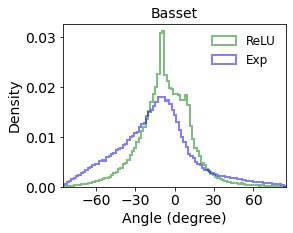

In [ ]:

fig = plt.figure(figsize=(4,3))
plt.hist(angles2_flat, 100, density=True, alpha=0.5, color='g', histtype='step', linewidth=2)
plt.hist(angles_flat, 100, density=True, alpha=0.5, color='b', histtype='step', linewidth=2)
plt.ylabel('Density', fontsize=14)
plt.xlabel('Angle (degree)', fontsize=14)
plt.title('Basset', fontsize=14)
plt.xticks([-60, -30, 0, 30, 60], fontsize=14)
#plt.tick_params(axis='x',  which='both', bottom=False,  top=False, labelbottom=False) 
plt.yticks(ticks=[0.0, 0.01, 0.02, 0.03], fontsize=14)
plt.xlim([-85, 85])
plt.legend(['ReLU', 'Exp'], fontsize=12, frameon=False)
fig.savefig('basset_angle_hist.pdf', format='pdf', dpi=200, bbox_inches='tight')


## Visualize saliency maps as sequence logos

In [ ]:


def plot_attribution_map(saliency_df, ax=None, figsize=(20,1), fontsize=16):
  """plot an attribution map using logomaker"""

  logomaker.Logo(saliency_df, figsize=figsize, ax=ax)
  if ax is None:
    ax = plt.gca()
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  #ax.yaxis.set_ticks_position('none')
  #ax.xaxis.set_ticks_position('none')
  ax.tick_params(axis="x", labelsize=fontsize)
  ax.tick_params(axis="y", labelsize=fontsize)
  plt.xticks([])


def plot_angle_logo(angles, ax=None, figsize=(20,1), fontsize=16):
  L = len(angles)
  counts_df = pd.DataFrame(data=0.0, columns=list('∧'), index=list(range(L)))
  for l in range(L):
    counts_df.iloc[l,0] = angles[l]

  logomaker.Logo(counts_df, figsize=figsize, ax=ax)  
  if ax is None:
      ax = plt.gca()
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.xaxis.set_ticks_position('none')
  plt.xticks([])
  ax.set_ylabel('Angle', fontsize=fontsize)
  ax.tick_params(axis="x", labelsize=fontsize)
  ax.tick_params(axis="y", labelsize=fontsize)


#### Basset-exp 

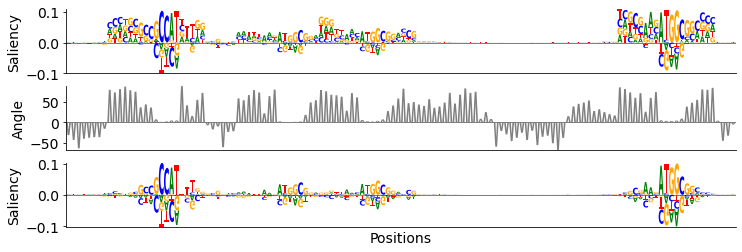

In [ ]:
index = 11692
plot_range = range(175,305)

X = np.expand_dims(x_test[index], axis=0)
sal_scores = np.expand_dims(saliency_scores[index], axis=0)

sal_scores_correct = sal_scores - np.mean(sal_scores, axis=2, keepdims=True)

saliency_df = tfomics.impress.matrix_to_df(X, sal_scores[0,plot_range,:])
saliency_df2 = tfomics.impress.matrix_to_df(X, sal_scores_correct[0,plot_range,:])

fig = plt.figure(figsize=(12,4))
ax = plt.subplot(3,1,1)
plot_attribution_map(saliency_df, ax, figsize=(20,1), fontsize=14)
ax.set_ylabel('Saliency', fontsize=14)
plt.yticks([-.1,0,.1])
ax = plt.subplot(3,1,2)
plot_angle_logo(angles[index][plot_range], ax, figsize=(20,1), fontsize=14)
ax = plt.subplot(3,1,3)
plot_attribution_map(saliency_df2, ax, figsize=(20,1), fontsize=14) 
ax.set_ylabel('Saliency', fontsize=14)
plt.yticks([-.1,0,.1])
ax.set_xlabel('Positions', fontsize=14)
fig.savefig('basset_exp_11692.pdf', format='pdf', dpi=200, bbox_inches='tight')



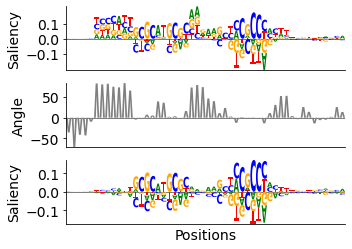

In [ ]:
index = 17677
plot_range = range(260,310)

X = np.expand_dims(x_test[index], axis=0)
sal_scores = np.expand_dims(saliency_scores[index], axis=0)

sal_scores_correct = sal_scores - np.mean(sal_scores, axis=2, keepdims=True)

saliency_df = tfomics.impress.matrix_to_df(X, sal_scores[0,plot_range,:])
saliency_df2 = tfomics.impress.matrix_to_df(X, sal_scores_correct[0,plot_range,:])

fig = plt.figure(figsize=(5,4))
ax = plt.subplot(3,1,1)
plot_attribution_map(saliency_df, ax, figsize=(20,1), fontsize=14)
ax.set_ylabel('Saliency', fontsize=14)
plt.yticks([-.1,0,.1])
ax = plt.subplot(3,1,2)
plot_angle_logo(angles[index][plot_range], ax, figsize=(20,1), fontsize=14)
ax = plt.subplot(3,1,3)
plot_attribution_map(saliency_df2, ax, figsize=(20,1), fontsize=14) 
ax.set_ylabel('Saliency', fontsize=14)
plt.yticks([-.1,0,.1])
ax.set_xlabel('Positions', fontsize=14)
fig.savefig('basset_exp_17677.pdf', format='pdf', dpi=200, bbox_inches='tight')





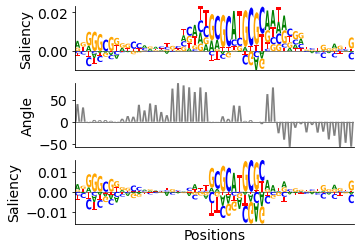

In [ ]:
index = 14764

plot_range = range(250,300)
X = np.expand_dims(x_test[index], axis=0)
sal_scores = np.expand_dims(saliency_scores2[index], axis=0)

sal_scores_correct = sal_scores - np.mean(sal_scores, axis=2, keepdims=True)

saliency_df = tfomics.impress.matrix_to_df(X, sal_scores[0,plot_range,:])
saliency_df2 = tfomics.impress.matrix_to_df(X, sal_scores_correct[0,plot_range,:])

fig = plt.figure(figsize=(5,4))
ax = plt.subplot(3,1,1)
plot_attribution_map(saliency_df, ax, figsize=(20,1), fontsize=14)
ax.set_ylabel('Saliency', fontsize=14)
#plt.yticks([-.1,0,.1])
ax = plt.subplot(3,1,2)
plot_angle_logo(angles[index][plot_range], ax, figsize=(20,1), fontsize=14)
ax = plt.subplot(3,1,3)
plot_attribution_map(saliency_df2, ax, figsize=(20,1), fontsize=14) 
ax.set_ylabel('Saliency', fontsize=14)
#plt.yticks([-.1,0,.1])
ax.set_xlabel('Positions', fontsize=14)
fig.savefig('basset_relu_14764.pdf', format='pdf', dpi=200, bbox_inches='tight')




#### Basset-relu

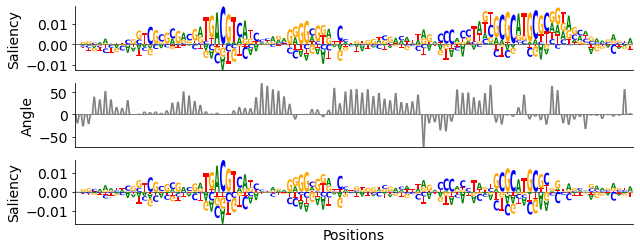

In [ ]:
index = 12246

plot_range = range(250,350)
X = np.expand_dims(x_test[index], axis=0)
sal_scores = np.expand_dims(saliency_scores2[index], axis=0)

sal_scores_correct = sal_scores - np.mean(sal_scores, axis=2, keepdims=True)

saliency_df = tfomics.impress.matrix_to_df(X, sal_scores[0,plot_range,:])
saliency_df2 = tfomics.impress.matrix_to_df(X, sal_scores_correct[0,plot_range,:])

fig = plt.figure(figsize=(10,4))
ax = plt.subplot(3,1,1)
plot_attribution_map(saliency_df, ax, figsize=(20,1), fontsize=14)
ax.set_ylabel('Saliency', fontsize=14)
#plt.yticks([-.1,0,.1])
ax = plt.subplot(3,1,2)
plot_angle_logo(angles[index][plot_range], ax, figsize=(20,1), fontsize=14)
ax = plt.subplot(3,1,3)
plot_attribution_map(saliency_df2, ax, figsize=(20,1), fontsize=14) 
ax.set_ylabel('Saliency', fontsize=14)
#plt.yticks([-.1,0,.1])
ax.set_xlabel('Positions', fontsize=14)
fig.savefig('basset_relu_12246.pdf', format='pdf', dpi=200, bbox_inches='tight')




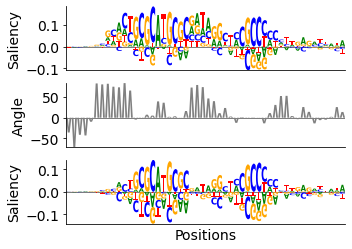

In [ ]:
index = 17677

plot_range = range(260,310)
X = np.expand_dims(x_test[index], axis=0)
sal_scores = np.expand_dims(saliency_scores2[index], axis=0)

sal_scores_correct = sal_scores - np.mean(sal_scores, axis=2, keepdims=True)

saliency_df = tfomics.impress.matrix_to_df(X, sal_scores[0,plot_range,:])
saliency_df2 = tfomics.impress.matrix_to_df(X, sal_scores_correct[0,plot_range,:])

fig = plt.figure(figsize=(5,4))
ax = plt.subplot(3,1,1)
plot_attribution_map(saliency_df, ax, figsize=(20,1), fontsize=14)
ax.set_ylabel('Saliency', fontsize=14)
#plt.yticks([-.1,0,.1])
ax = plt.subplot(3,1,2)
plot_angle_logo(angles[index][plot_range], ax, figsize=(20,1), fontsize=14)
ax = plt.subplot(3,1,3)
plot_attribution_map(saliency_df2, ax, figsize=(20,1), fontsize=14) 
ax.set_ylabel('Saliency', fontsize=14)
#plt.yticks([-.1,0,.1])
ax.set_xlabel('Positions', fontsize=14)
fig.savefig('basset_relu_17677.pdf', format='pdf', dpi=200, bbox_inches='tight')

